In [381]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import plotly.express as px
import scipy.stats
from matplotlib import pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D


# Torch
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset

#Sklearn
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix

Settings

In [382]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

### Loading dataset

In [383]:
ds_original = pd.read_csv('..\..\data\external\dataset_phishing.csv', header=0, delimiter=',',decimal=',')

print("Original dataset dimensions:", ds_original.shape)

Original dataset dimensions: (11430, 89)


In [384]:
# L' objectiu és predir si una url és de phishing o no, per tant la variable dependent serà STATUS.
y = ds_original[:]["status"] 
x = ds_original.drop(columns = "status")

print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

x

Number of samples: 11430
Number of features: 88


url  length_url  \
0                  http://www.crestonwood.com/router.php          37   
1      http://shadetreetechnology.com/V4/validation/a...          77   
2      https://support-appleld.com.secureupdate.duila...         126   
3                                     http://rgipt.ac.in          18   
4      http://www.iracing.com/tracks/gateway-motorspo...          55   
...                                                  ...         ...   
11425      http://www.fontspace.com/category/blackletter          45   
11426  http://www.budgetbots.com/server.php/Server%20...          84   
11427  https://www.facebook.com/Interactive-Televisio...         105   
11428             http://www.mypublicdomainpictures.com/          38   
11429  http://174.139.46.123/ap/signin?openid.pape.ma...         477   

       length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  \
0                   19   0        3           0      0      0       0      0   
1                   23   1        1           0      0      0       0      0   
2                   50   1        4           1      0      1       2      0   
3                   11   0        2           0      0      0       0      0   
4                   15   0        2           2      0      0       0      0   
...                ...  ..      ...         ...    ...    ...     ...    ...   
11425               17   0        2           0      0      0       0      0   
11426               18   0        5           0      1      1       0      0   
11427               16   1        2           6      0      1       0      0   
11428               30   0        2           0      0      0       0      0   
11429               14   1       24           0      1      1       9      0   

       nb_eq  nb_underscore  nb_tilde  nb_percent  nb_slash  nb_star  \
0          0              0         0           0         3        0   
1          0              0         0           0         5        0   
2          3              2         0           0         5        0   
3          0              0         0           0         2        0   
4          0              0         0           0         5        0   
...      ...            ...       ...         ...       ...      ...   
11425      0              0         0           0         4        0   
11426      1              0         0           1         5        0   
11427      1              1         0           0         5        0   
11428      0              0         0           0         3        0   
11429      9             18         0          23         4        0   

       nb_colon  nb_comma  nb_semicolumn  nb_dollar  nb_space  nb_www  nb_com  \
0             1         0              0          0         0       1       0   
1             1         0              0          0         0       0       0   
2             1         0              0          0         0       0       1   
3             1         0              0          0         0       0       0   
4             1         0              0          0         0       1       0   
...         ...       ...            ...        ...       ...     ...     ...   
11425         1         0              0          0         0       1       0   
11426         1         0              0          0         1       1       1   
11427         1         0              0          0         0       1       0   
11428         1         0              0          0         0       1       0   
11429         1         0              9          0         0       1       0   

       nb_dslash  http_in_path  https_token     ratio_digits_url  \
0              0             0            1                  0.0   
1              0             0            1  0.22077922100000005   
2              0             0            0          0.150793651   
3              0             0            1                  0.0   
4              0             0            1      

## Data preprocessing

### - Data cleaning

Searching for empty or unknown values in the dataset

In [385]:
print("Null values:", x.isnull().sum().sum())
print("NA values:", x.isna().sum().sum())

print("\nColumns with values equal to -1:\n", ((x == -1).sum())[((x == -1).sum() != 0).tolist()])


Null values: 0
NA values: 0

Columns with values equal to -1:
 domain_registration_length      46
domain_age                    1781
dtype: int64


Replacing unknown values with the mean of the known values

In [386]:
known_domain_age = x.loc[x['domain_age'] != -1, 'domain_age']
mean_domain_age = known_domain_age.sum()/len(known_domain_age)
mean_domain_age

x.loc[x["domain_age"] == -1, 'domain_age'] = mean_domain_age

known_domain_registration_length = x.loc[x['domain_registration_length'] != -1, 'domain_registration_length']
mean_domain_registration_length = known_domain_registration_length.sum()/len(known_domain_registration_length)
mean_domain_registration_length

x.loc[x["domain_registration_length"] == -1, 'domain_registration_length'] = mean_domain_registration_length

In [387]:
(x[["domain_age", "domain_registration_length"]] == -1).sum()

domain_age                    0
domain_registration_length    0
dtype: int64

The "url" feature is not useful since all the information that can be extracted from it is already collected in the rest of columns.

In [388]:
x = x.drop(columns = "url")

### - Data conversion

Incialment a $Y$ teniem les etiques de "phishing" i "legitimate". Per poder fer regressió ens interessa convertir-les en un valor binari on 1 indica _Phishing_ i 0 no.
També veïem que les mostres estan repartides al 50% entre les dues categoríes (Com s'indica a la descripció de Kaggle).

In [389]:
print(y.describe())

status_labels = y.copy()
y = y.replace({"phishing" : 1, "legitimate" : 0})

print("\nContingut de Y:", set(y))

print("\nDimensionalitat de X:", x.shape)

count          11430
unique             2
top       legitimate
freq            5715
Name: status, dtype: object

Contingut de Y: {0, 1}

Dimensionalitat de X: (11430, 87)


Les columnes de $X$ que tenen nombres decimals apareixen amb un tipus de dada desconegut anomenat _object_. Aixó pot crear problemes més endavant, per tant es bona idea fer una conversió a tipus _float_.

In [390]:
type_of_cols = [x.dtypes == object][0]
for col in range(x.shape[1]):
    if type_of_cols[col]:
        x[x.columns[col]] = x[x.columns[col]].astype('float')

Now $X$ contain just numeric values.

### - Data normalization

First we have to determine which features are categorical.

In [391]:
x

length_url  length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  \
0              37               19   0        3           0      0      0   
1              77               23   1        1           0      0      0   
2             126               50   1        4           1      0      1   
3              18               11   0        2           0      0      0   
4              55               15   0        2           2      0      0   
...           ...              ...  ..      ...         ...    ...    ...   
11425          45               17   0        2           0      0      0   
11426          84               18   0        5           0      1      1   
11427         105               16   1        2           6      0      1   
11428          38               30   0        2           0      0      0   
11429         477               14   1       24           0      1      1   

       nb_and  nb_or  nb_eq  nb_underscore  nb_tilde  nb_percent  nb_slash  \
0           0      0      0              0         0           0         3   
1           0      0      0              0         0           0         5   
2           2      0      3              2         0           0         5   
3           0      0      0              0         0           0         2   
4           0      0      0              0         0           0         5   
...       ...    ...    ...            ...       ...         ...       ...   
11425       0      0      0              0         0           0         4   
11426       0      0      1              0         0           1         5   
11427       0      0      1              1         0           0         5   
11428       0      0      0              0         0           0         3   
11429       9      0      9             18         0          23         4   

       nb_star  nb_colon  nb_comma  nb_semicolumn  nb_dollar  nb_space  \
0            0         1         0              0          0         0   
1            0         1         0              0          0         0   
2            0         1         0              0          0         0   
3            0         1         0              0          0         0   
4            0         1         0              0          0         0   
...        ...       ...       ...            ...        ...       ...   
11425        0         1         0              0          0         0   
11426        0         1         0              0          0         1   
11427        0         1         0              0          0         0   
11428        0         1         0              0          0         0   
11429        0         1         0              9          0         0   

       nb_www  nb_com  nb_dslash  http_in_path  https_token  ratio_digits_url  \
0           1       0          0             0            1             0.000   
1           0       0          0             0            1             0.221   
2           0       1          0             0            0             0.151   
3           0       0          0             0            1             0.000   
4           1       0          0             0            1             0.000   
...       ...     ...        ...           ...          ...               ...   
11425       1       0          0             0            1             0.000   
11426       1       1          0             0            1             0.024   
11427       1       0          0             0            0             0.143   
11428       1       0          0             0            1             0.000   
11429       1       0          0             4            1             0.086   

       ratio_digits_host  punycode  port  tld_in_path  tld_in_subdomain  \
0                  0.000         0     0            0                 0   
1                  0.000         0     0            0                 0   
2                  0.000         0     0            0     

In [392]:
categorical_features = ["ip", "http_in_path", "https_token", "punycode", "port", "tld_in_path", "tld_in_subdomain", "abnormal_subdomain", "prefix_suffix", "random_domain", "shortening_service", "path_extension",
"domain_in_brand", "brand_in_subdomain", "brand_in_path", "suspecious_tld", "login_form", "external_favicon", "submit_email", "sfh", "iframe", "popup_window", "onmouseover", 
"right_clic", "empty_title", "domain_in_title", "domain_with_copyright", "whois_registered_domain", "dns_record", "google_index"]

non_categorical_features = [i for i in x.columns if (i not in categorical_features)]

x_non_categorical = x.drop(columns = categorical_features)
x_categorical = x[categorical_features]

In [393]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

x_non_categorical_standard = scaler.fit_transform(x_non_categorical)

df = pd.DataFrame(x_non_categorical_standard)
df.columns = non_categorical_features

x_standard = pd.concat([t, x_categorical], axis = 1)

## Feature selection

A good idea for discarding some columns would be to drop those whose mean is or is very close to 0. We can do this only with the features that represent some kind of counter because that means that most of the samples doesn't register that feature.

In [394]:
columns_to_drop = []

for col in range(x.shape[1]):
    name_of_feature = x.columns[col]
    if abs(np.mean(x[name_of_feature])) <= 0.01:
        columns_to_drop.append(name_of_feature)
        
print(x[columns_to_drop].shape)
x[columns_to_drop].describe()

(11430, 21)


nb_or  nb_tilde   nb_star  nb_comma  nb_dollar  nb_dslash  punycode  \
count 11430.000 11430.000 11430.000 11430.000  11430.000  11430.000 11430.000   
mean      0.000     0.007     0.001     0.004      0.002      0.007     0.000   
std       0.000     0.081     0.026     0.103      0.077      0.081     0.019   
min       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
25%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
50%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
75%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
max       0.000     1.000     1.000     4.000      6.000      1.000     1.000   

           port  path_extension  nb_external_redirection  brand_in_subdomain  \
count 11430.000       11430.000                11430.000           11430.000   
mean      0.002           0.000                    0.003               0.004   
std       0.049           0.013                    0.056               0.064   
min       0.000           0.000                    0.000               0.000   
25%       0.000           0.000                    0.000               0.000   
50%       0.000           0.000                    0.000               0.000   
75%       0.000           0.000                    0.000               0.000   
max       1.000           1.000                    1.000               1.000   

       brand_in_path  ratio_nullHyperlinks  ratio_intRedirection  \
count      11430.000             11430.000             11430.000   
mean           0.005                 0.000                 0.000   
std            0.070                 0.000                 0.000   
min            0.000                 0.000                 0.000   
25%            0.000                 0.000                 0.000   
50%            0.000                 0.000                 0.000   
75%            0.000                 0.000                 0.000   
max            1.000                 0.000                 0.000   

       ratio_intErrors  submit_email       sfh    iframe  popup_window  \
count        11430.000     11430.000 11430.000 11430.000     11430.000   
mean             0.000         0.000     0.000     0.001         0.006   
std              0.000         0.000     0.000     0.036         0.077   
min              0.000         0.000     0.000     0.000         0.000   
25%              0.000         0.000     0.000     0.000         0.000   
50%              0.000         0.000     0.000     0.000         0.000   
75%              0.000         0.000     0.000     0.000         0.000   
max              0.000         0.000     0.000     1.000         1.000   

       onmouseover  right_clic  
count    11430.000   11430.000  
mean         0.001       0.001  
std          0.034       0.037  
min          0.000       0.000  
25%          0.000       0.000  
50%          0.000       0.000  
75%          0.000       0.000  
max          1.000       1.000

Veient els màxims i mínims d'aquestes columnes queda clar que totes aquestes columnes indiquen un compte d'alguna cosa o són variables binaries i, en qualsevol cas, no donen suficient informació per ajudar en la classifició.

In [395]:
x_standard

length_url  length_hostname  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  \
0          -0.436           -0.194    0.379      -0.478 -0.143 -0.387  -0.198   
1           0.287            0.177   -1.081      -0.478 -0.143 -0.387  -0.198   
2           1.173            2.683    1.109       0.001 -0.143  2.356   2.238   
3          -0.780           -0.936   -0.351      -0.478 -0.143 -0.387  -0.198   
4          -0.111           -0.565   -0.351       0.480 -0.143 -0.387  -0.198   
...           ...              ...      ...         ...    ...    ...     ...   
11425      -0.292           -0.380   -0.351      -0.478 -0.143 -0.387  -0.198   
11426       0.414           -0.287    1.839      -0.478  6.288  2.356  -0.198   
11427       0.793           -0.472   -0.351       2.397 -0.143  2.356  -0.198   
11428      -0.418            0.827   -0.351      -0.478 -0.143 -0.387  -0.198   
11429       7.521           -0.658   15.712      -0.478  6.288  2.356  10.761   

       nb_or  nb_eq  nb_underscore  nb_tilde  nb_percent  nb_slash  nb_star  \
0      0.000 -0.294         -0.295    -0.082      -0.084    -0.685   -0.026   
1      0.000 -0.294         -0.295    -0.082      -0.084     0.377   -0.026   
2      0.000  2.712          1.534    -0.082      -0.084     0.377   -0.026   
3      0.000 -0.294         -0.295    -0.082      -0.084    -1.216   -0.026   
4      0.000 -0.294         -0.295    -0.082      -0.084     0.377   -0.026   
...      ...    ...            ...       ...         ...       ...      ...   
11425  0.000 -0.294         -0.295    -0.082      -0.084    -0.154   -0.026   
11426  0.000  0.708         -0.295    -0.082       0.598     0.377   -0.026   
11427  0.000  0.708          0.620    -0.082      -0.084     0.377   -0.026   
11428  0.000 -0.294         -0.295    -0.082      -0.084    -0.685   -0.026   
11429  0.000  8.722         16.169    -0.082      15.601    -0.154   -0.026   

       nb_colon  nb_comma  nb_semicolumn  nb_dollar  nb_space  nb_www  nb_com  \
0        -0.116    -0.039         -0.104     -0.025    -0.093   1.099  -0.338   
1        -0.116    -0.039         -0.104     -0.025    -0.093  -0.894  -0.338   
2        -0.116    -0.039         -0.104     -0.025    -0.093  -0.894   2.301   
3        -0.116    -0.039         -0.104     -0.025    -0.093  -0.894  -0.338   
4        -0.116    -0.039         -0.104     -0.025    -0.093   1.099  -0.338   
...         ...       ...            ...        ...       ...     ...     ...   
11425    -0.116    -0.039         -0.104     -0.025    -0.093   1.099  -0.338   
11426    -0.116    -0.039         -0.104     -0.025     2.570   1.099   2.301   
11427    -0.116    -0.039         -0.104     -0.025    -0.093   1.099  -0.338   
11428    -0.116    -0.039         -0.104     -0.025    -0.093   1.099  -0.338   
11429    -0.116    -0.039         14.942     -0.025    -0.093   1.099  -0.338   

       nb_dslash  ratio_digits_url  ratio_digits_host  nb_subdomains  \
0         -0.081            -0.595             -0.268          1.206   
1         -0.081             1.876             -0.268         -1.933   
2         -0.081             1.093             -0.268          1.206   
3         -0.081            -0.595             -0.268         -0.364   
4         -0.081            -0.595             -0.268         -0.364   
...          ...               ...                ...            ...   
11425     -0.081            -0.595             -0.268         -0.364   
11426     -0.081            -0.328             -0.268          1.206   
11427     -0.081             1.004             -0.268         -0.364   
11428     -0.081            -0.595             -0.268         -0.364   
11429     -0.081             0.367              8.143          1.206   

       nb_redirection  nb_external_redirection  length_words_raw  char_repeat  \
0              -0.720                   -0.056            -0.401        0.225   
1               0.725                   -0.056            -0.401        0.225   
2   

In [396]:
x = x.drop(columns = columns_to_drop)
x_standard = x_standard.drop(columns = columns_to_drop)
print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

Number of samples: 11430
Number of features: 66


In [398]:
x_standard

length_url  length_hostname  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  \
0          -0.436           -0.194    0.379      -0.478 -0.143 -0.387  -0.198   
1           0.287            0.177   -1.081      -0.478 -0.143 -0.387  -0.198   
2           1.173            2.683    1.109       0.001 -0.143  2.356   2.238   
3          -0.780           -0.936   -0.351      -0.478 -0.143 -0.387  -0.198   
4          -0.111           -0.565   -0.351       0.480 -0.143 -0.387  -0.198   
...           ...              ...      ...         ...    ...    ...     ...   
11425      -0.292           -0.380   -0.351      -0.478 -0.143 -0.387  -0.198   
11426       0.414           -0.287    1.839      -0.478  6.288  2.356  -0.198   
11427       0.793           -0.472   -0.351       2.397 -0.143  2.356  -0.198   
11428      -0.418            0.827   -0.351      -0.478 -0.143 -0.387  -0.198   
11429       7.521           -0.658   15.712      -0.478  6.288  2.356  10.761   

       nb_eq  nb_underscore  nb_percent  nb_slash  nb_colon  nb_semicolumn  \
0     -0.294         -0.295      -0.084    -0.685    -0.116         -0.104   
1     -0.294         -0.295      -0.084     0.377    -0.116         -0.104   
2      2.712          1.534      -0.084     0.377    -0.116         -0.104   
3     -0.294         -0.295      -0.084    -1.216    -0.116         -0.104   
4     -0.294         -0.295      -0.084     0.377    -0.116         -0.104   
...      ...            ...         ...       ...       ...            ...   
11425 -0.294         -0.295      -0.084    -0.154    -0.116         -0.104   
11426  0.708         -0.295       0.598     0.377    -0.116         -0.104   
11427  0.708          0.620      -0.084     0.377    -0.116         -0.104   
11428 -0.294         -0.295      -0.084    -0.685    -0.116         -0.104   
11429  8.722         16.169      15.601    -0.154    -0.116         14.942   

       nb_space  nb_www  nb_com  ratio_digits_url  ratio_digits_host  \
0        -0.093   1.099  -0.338            -0.595             -0.268   
1        -0.093  -0.894  -0.338             1.876             -0.268   
2        -0.093  -0.894   2.301             1.093             -0.268   
3        -0.093  -0.894  -0.338            -0.595             -0.268   
4        -0.093   1.099  -0.338            -0.595             -0.268   
...         ...     ...     ...               ...                ...   
11425    -0.093   1.099  -0.338            -0.595             -0.268   
11426     2.570   1.099   2.301            -0.328             -0.268   
11427    -0.093   1.099  -0.338             1.004             -0.268   
11428    -0.093   1.099  -0.338            -0.595             -0.268   
11429    -0.093   1.099  -0.338             0.367              8.143   

       nb_subdomains  nb_redirection  length_words_raw  char_repeat  \
0              1.206          -0.720            -0.401        0.225   
1             -1.933           0.725            -0.401        0.225   
2              1.206           0.725             1.035       -0.194   
3             -0.364           0.725            -0.939       -0.614   
4             -0.364           0.725            -0.042        0.015   
...              ...             ...               ...          ...   
11425         -0.364           0.725            -0.401        0.225   
11426          1.206           0.725             1.035        0.015   
11427         -0.364          -0.720             1.214        0.435   
11428         -0.364          -0.720            -0.760        0.015   
11429          1.206           0.725            15.033        1.064   

       shortest_words_raw  shortest_word_host  shortest_word_path  \
0                  -0.058              -0.512               0.201   
1                  -0.510               3.547              -0.133   
2                  -0.510              -0.512              -0.133   
3                   0.847              -0.005              -0.800   
4                  -0.058         

In [399]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x_standard.values, y)

r2_table = np.zeros((x_train.shape[1], 2))

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = LinearRegression()
    regr.fit(x_t, y_train)
    
    r2 = r2_score(y_val, regr.predict(x_v))
    
    r2_table[i, 1] = r2
    r2_table[i, 0] = i

In [401]:
x.shape

(11430, 66)

We create a reduced dataset with the best atributes

In [404]:
best_atributes = r2_table[r2_table[:, 1].argsort()[::-1]][:,0].astype('int')


reduced_dataset = x[x.columns[best_atributes[:15]]]
reduced_dataset = reduced_dataset.assign(status = y.values)

X = reduced_dataset.drop(columns='status').values
Y = reduced_dataset.filter(['status']).values

In [405]:
reduced_dataset

page_rank  ratio_extHyperlinks  nb_space  nb_hyperlinks  nb_com  \
0              4                0.471         0             17       0   
1              2                0.033         0             30       0   
2              0                0.000         0              4       1   
3              3                0.027         0            149       0   
4              6                0.529         0            102       0   
...          ...                  ...       ...            ...     ...   
11425          6                0.116         0            199       0   
11426          0                0.000         1              3       1   
11427         10                0.529         0             68       0   
11428          4                0.625         0             32       0   
11429          0                0.571         0             21       0   

       domain_age  shortest_word_path  shortest_words_raw  nb_extCSS  nb_at  \
0        4812.587                   3                   3          0      0   
1        5767.000                   2                   2          0      0   
2        4004.000                   2                   2          0      0   
3        4812.587                   0                   5          0      0   
4        8175.000                   4                   3          0      0   
...           ...                 ...                 ...        ...    ...   
11425    5396.000                   8                   3          0      0   
11426    6728.000                   3                   3          0      1   
11427    8515.000                   1                   1          5      0   
11428    2836.000                   0                   3          1      0   
11429    4812.587                   1                   1          3      1   

       nb_percent  length_hostname  http_in_path  length_url  nb_and  status  
0               0               19             0          37       0       0  
1               0               23             0          77       0       1  
2               0               50             0         126       2       1  
3               0               11             0          18       0       0  
4               0               15             0          55       0       0  
...           ...              ...           ...         ...     ...     ...  
11425           0               17             0          45       0       0  
11426           1               18             0          84       0       1  
11427           0               16             0         105       0       0  
11428           0               30             0          38       0       0  
11429          23               14             4         477       9       1  

[11430 rows x 16 columns]

Relació entre variables no categoriques

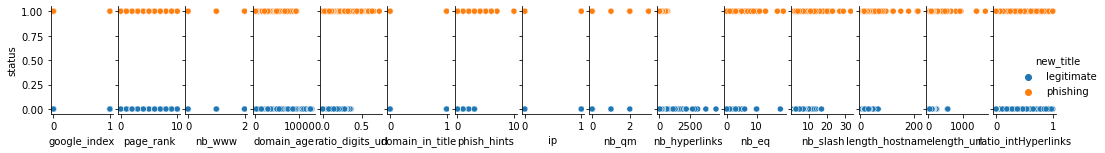

In [53]:
reduced_dataset.insert(reduced_dataset.shape[1], "Status", status_labels)
relacio = sns.pairplot(reduced_dataset, hue = "Status", y_vars = ["status"], x_vars = list(reduced_dataset.columns[:-2]))
relacio.fig.set_size_inches(15,2)
relacio._legend.set_title("new_title")
reduced_dataset.drop(columns = "Status")
reduced_dataset = reduced_dataset.drop(columns = "Status")

Correlació entre les variables independents i la dependent

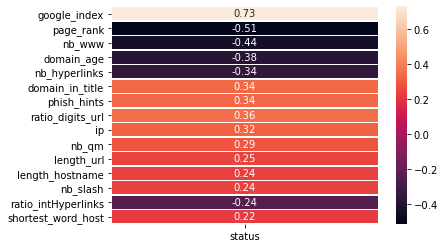

In [14]:
correlacio = reduced_dataset.corr()

plt.figure()
ax = sns.heatmap(pd.DataFrame(correlacio["status"][:-1]), annot=True, linewidths=.5)

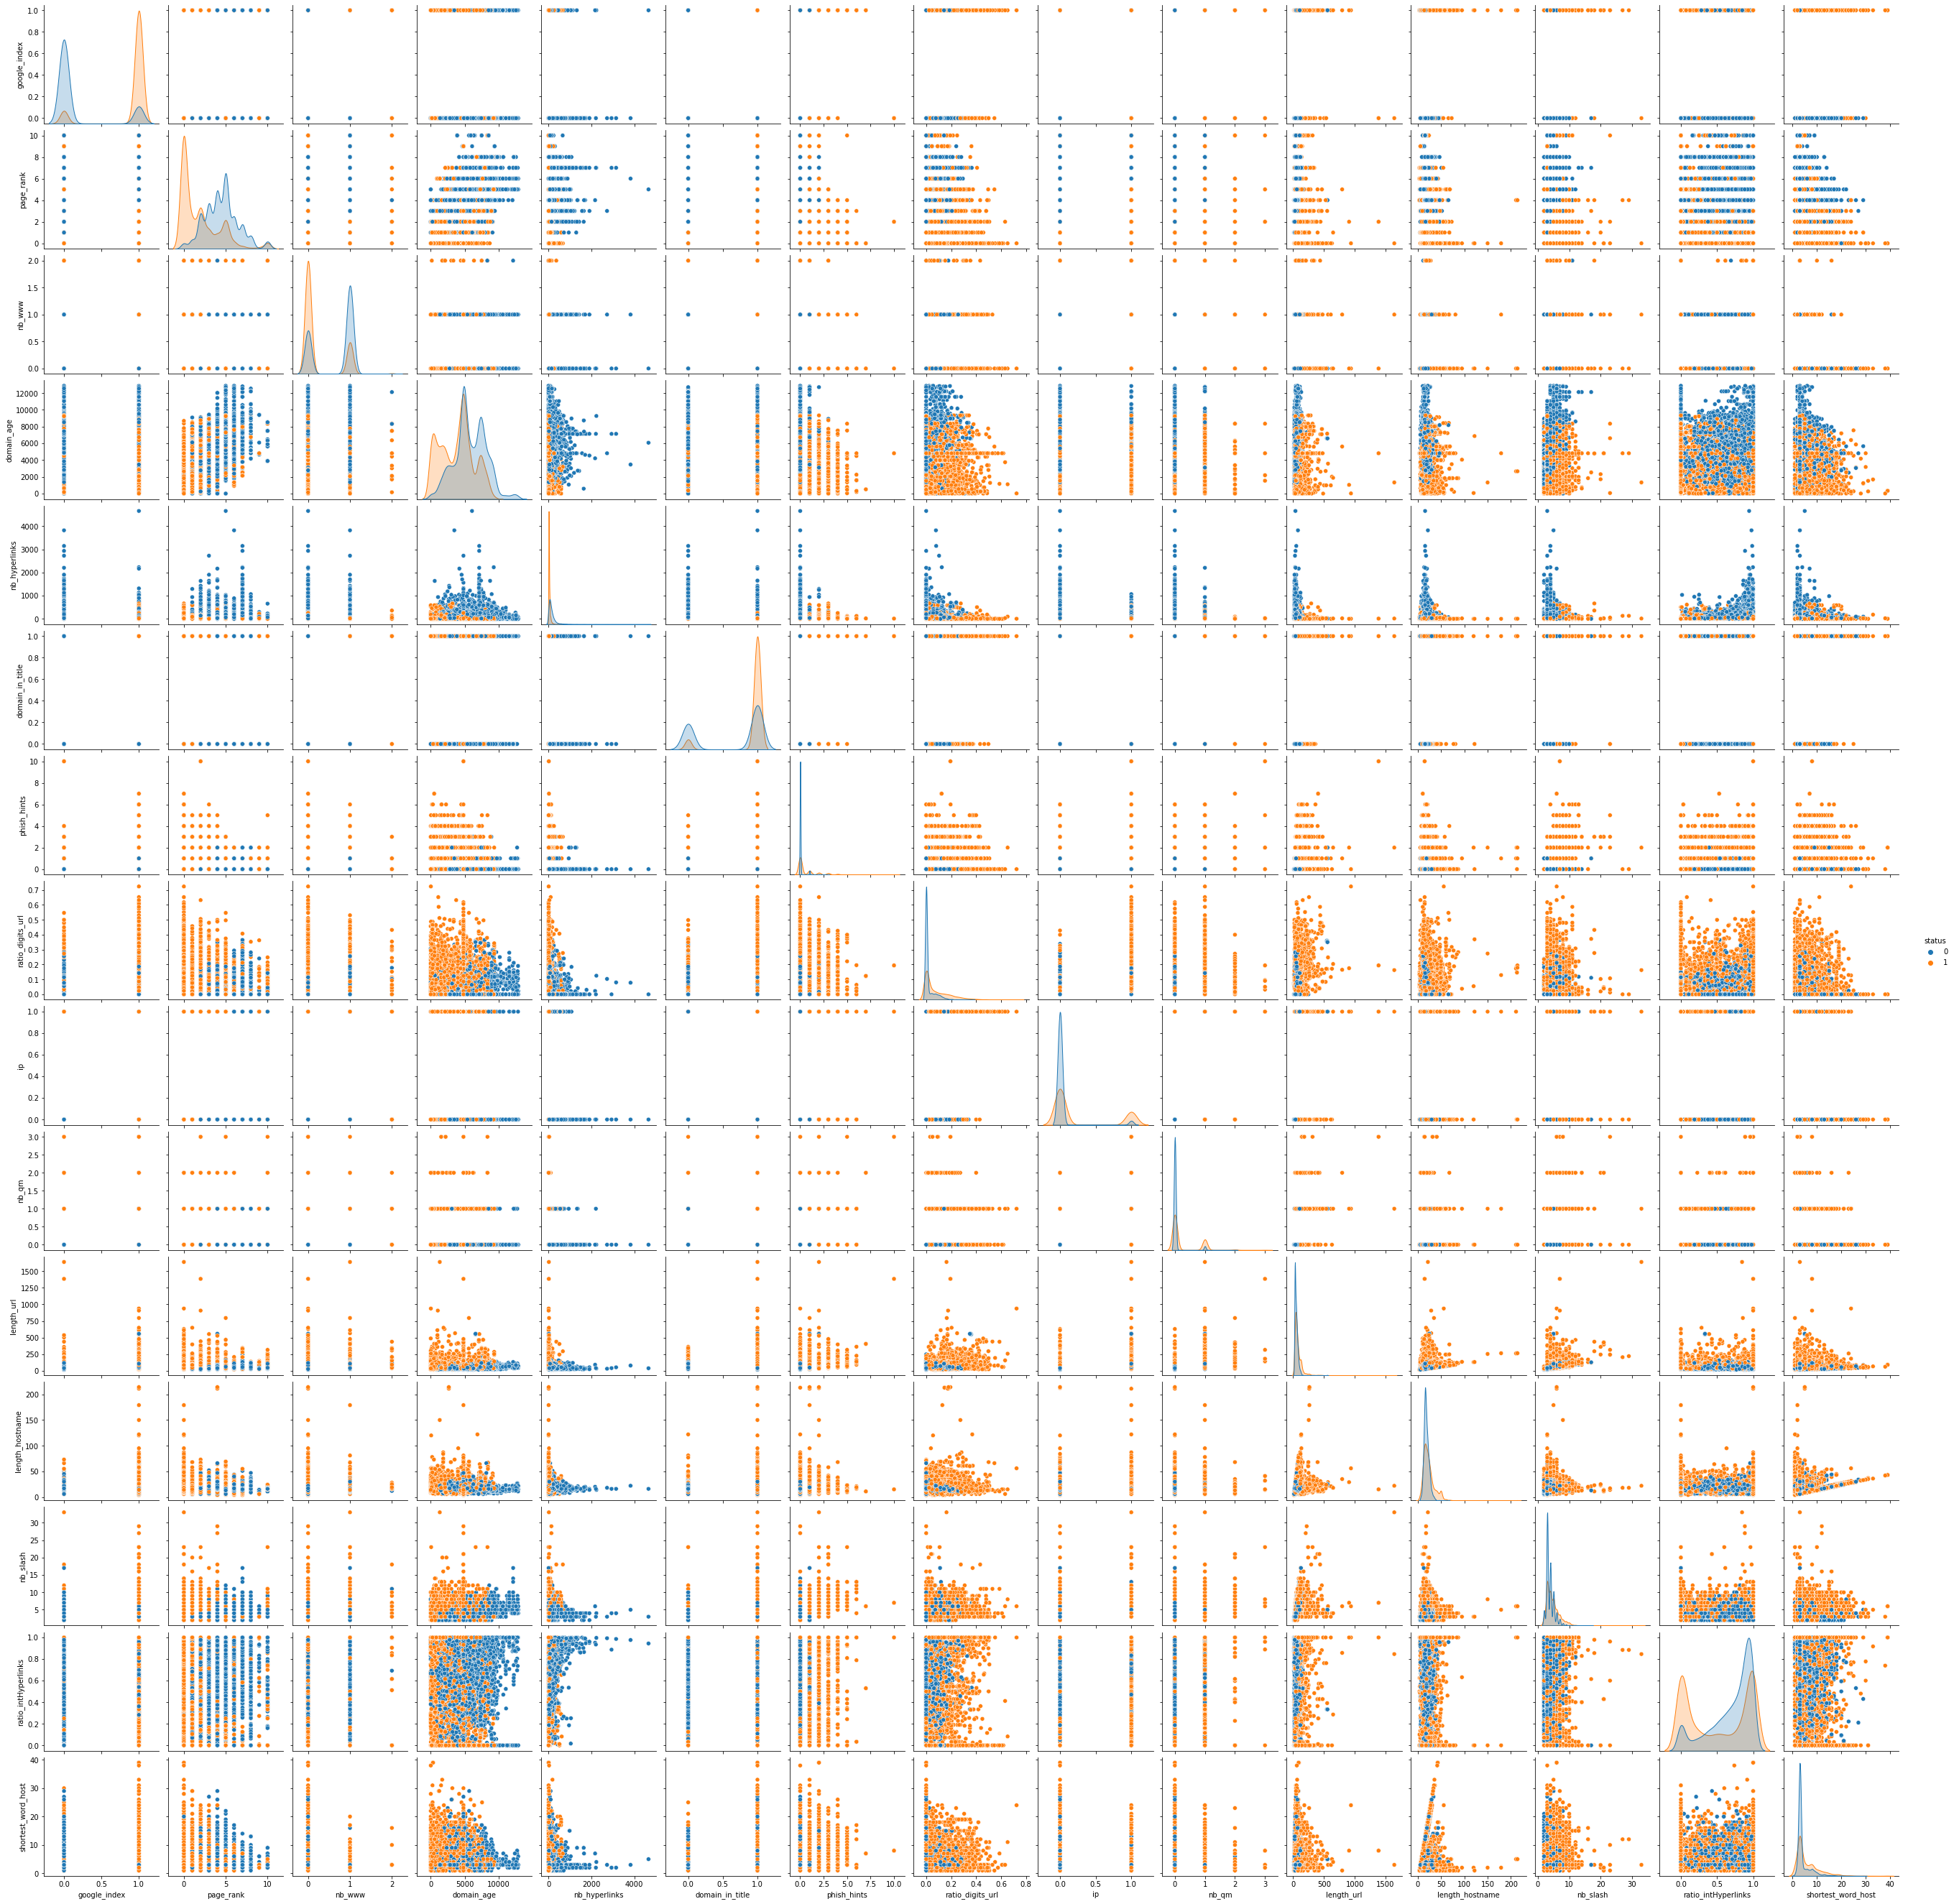

In [15]:
relacio = sns.pairplot(reduced_dataset, hue = "status")

Utilities

In [16]:
def visualize_confusion_matrix(y_pred, y_real):
    # mostra la matriu de confusió
    cm = confusion_matrix(y_real, y_pred)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

PCA Analysis

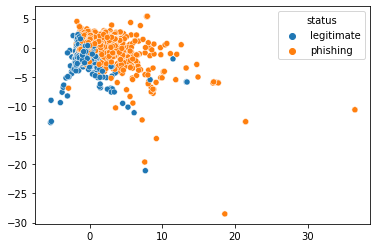

In [406]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

X_torch = torch.tensor(scaled_X)
Y_torch = torch.tensor(Y)
 
V = torch.pca_lowrank(X_torch, q=None, center=False, niter=2)[2]
pca = torch.matmul(X_torch, V[:, :2])

sns.scatterplot(x = pca[:, 0], y = pca[:, 1], hue = status_labels);

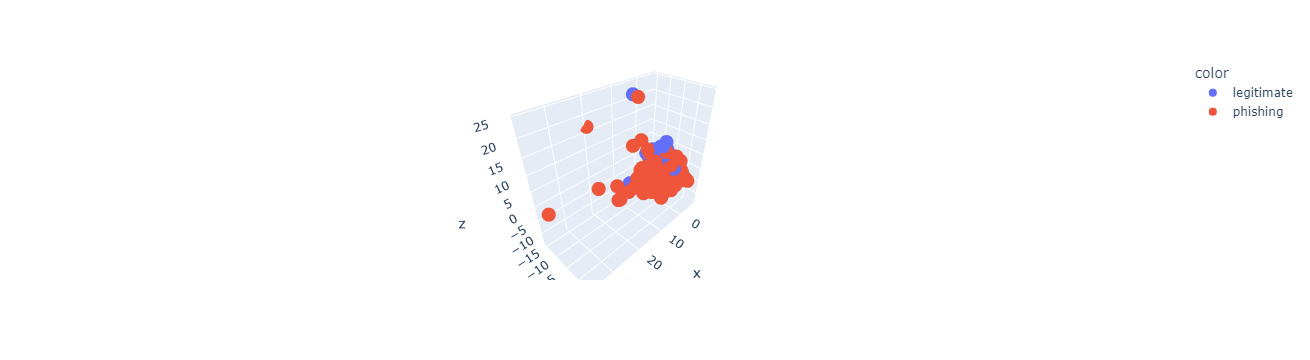

In [408]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

X_torch = torch.tensor(scaled_X)
Y_torch = torch.tensor(Y)
 
V = torch.pca_lowrank(X_torch, q=None, center=False, niter=3)[2]
pca = torch.matmul(X_torch, V[:, :3])

df = px.data.iris()
fig = px.scatter_3d(x = pca[:, 0], y = pca[:, 1], z = pca[:, 2], color = status_labels)
fig.show()

#### Logistic regression

In [409]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = \
    train_test_split(scaled, Y, test_size=0.80, random_state=42)

X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

X_torch, Y_torch = torch.Tensor(scaled), torch.Tensor(Y)

data_torch = torch.cat((X_torch, Y_torch), 1)

In [410]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [411]:
epochs = 2000
input_dim = X.shape[1] # Independent variables 
output_dim = 1 # Single binary output 
learning_rate = 0.01

In [412]:
model = LogisticRegression(input_dim,output_dim) #Creem el model

criterion = torch.nn.BCELoss() # Definim el criteri de la funció de cost

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Definim el mètode per reduir el cost

In [414]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(outputs, labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter += 1
    if iter % (epochs/5) == 0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = model(X_test)
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(outputs.round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  48%|████▊     | 962/2000 [00:00<00:00, 2519.03it/s]

Iteration: 400. 
Test - Loss: 0.4030793309211731. Accuracy: 83.24584426946632
Train -  Loss: 0.3919364809989929. Accuracy: 83.24584426946632

Iteration: 800. 
Test - Loss: 0.400691956281662. Accuracy: 83.3005249343832
Train -  Loss: 0.388947457075119. Accuracy: 83.46456692913385



Training Epochs:  75%|███████▍  | 1494/2000 [00:00<00:00, 2569.28it/s]

Iteration: 1200. 
Test - Loss: 0.3990151882171631. Accuracy: 83.32239720034995
Train -  Loss: 0.38674411177635193. Accuracy: 83.50831146106736

Iteration: 1600. 
Test - Loss: 0.39778879284858704. Accuracy: 83.43175853018373
Train -  Loss: 0.3850698173046112. Accuracy: 83.59580052493439



Training Epochs: 100%|██████████| 2000/2000 [00:00<00:00, 2407.08it/s]

Iteration: 2000. 
Test - Loss: 0.3968867361545563. Accuracy: 83.47550306211724
Train -  Loss: 0.3837660849094391. Accuracy: 83.85826771653544



### SVM

In [415]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = \
    train_test_split(scaled, Y, test_size=0.80, random_state=1)

C = 0.05
models = (svm.SVC(),
         svm.LinearSVC(C=C),
         svm.SVC(kernel = 'rbf', gamma = 0.7, C=C),
         svm.SVC(kernel = 'poly', degree = 2, C=C),
         svm.SVC(kernel = 'poly', degree = 3, C=C))

models = (model.fit(X_train,y_train.flatten()) for model in models)

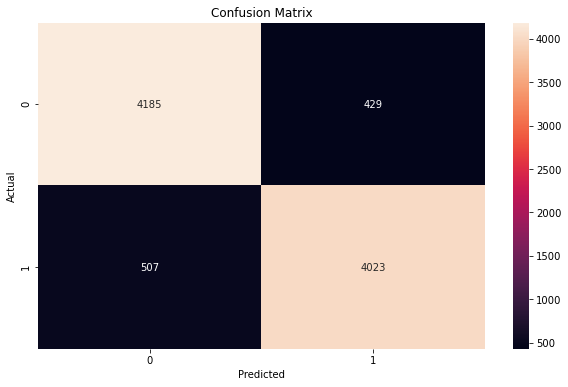

Accuracy "Without kernel": 0.8976377952755905 




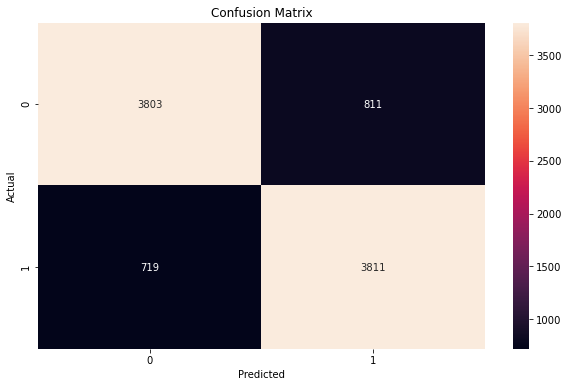

Accuracy "Linear kernel": 0.8326771653543307 




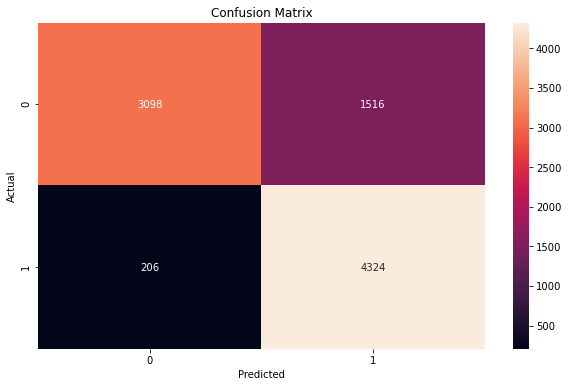

Accuracy "RBF kernel": 0.8116797900262467 




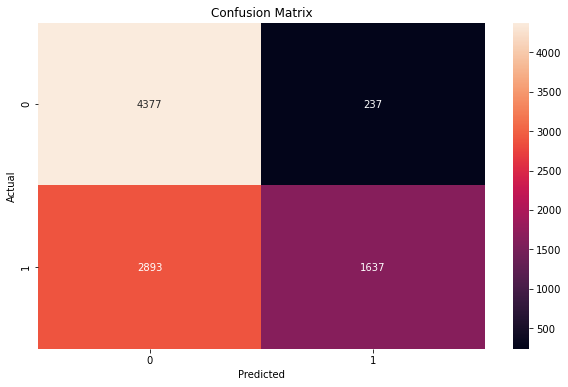

Accuracy "2nd degree Polynomial kernel": 0.6576990376202975 




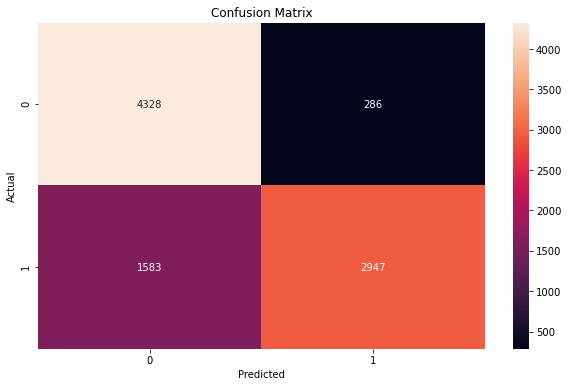

Accuracy "3nd degree Polynomial kernel": 0.7956036745406824 




In [416]:
kernel_names = ["Without kernel", "Linear kernel", "RBF kernel",\
                "2nd degree Polynomial kernel", "3nd degree Polynomial kernel"]

for i, model in enumerate(models):
    predict = model.predict(X_test)
    visualize_confusion_matrix(predict, y_test.flatten())
    print("Accuracy \"" + kernel_names[i] + str("\":"), sum(predict == y_test.flatten())/predict.size, "\n\n")
    